In [1]:
# Import necessary libraries
import torch


import jovian
import torch.nn as nn
import pandas as pd
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, random_split



<IPython.core.display.Javascript object>

In [2]:
# Load the dataset
DATA_FILENAME = "car_data.csv"
dataframe_raw = pd.read_csv(DATA_FILENAME)
dataframe_raw.head()


,Car_Name,Year,Selling_Price,Present_Price,Kms_Driven,Fuel_Type,Seller_Type,Transmission,Owner
0,ritz,2014,3.35,5.59,27000,Petrol,Dealer,Manual,0
1,sx4,2013,4.75,9.54,43000,Diesel,Dealer,Manual,0
2,ciaz,2017,7.25,9.85,6900,Petrol,Dealer,Manual,0
3,wagon r,2011,2.85,4.15,5200,Petrol,Dealer,Manual,0
4,swift,2014,4.60,6.87,42450,Diesel,Dealer,Manual,0


In [3]:
your_name = "Hritik Kumar"  # At least 5 characters

def customize_dataset(dataframe_raw, rand_str):
    dataframe = dataframe_raw.copy(deep=True)
    # Drop some rows
    dataframe = dataframe.sample(int(0.95 * len(dataframe)), random_state=int(ord(rand_str[0])))
    # Scale input
    dataframe.Year = dataframe.Year * ord(rand_str[1]) / 100.0
    # Scale target
    dataframe.Selling_Price = dataframe.Selling_Price * ord(rand_str[2]) / 100.0
    # Drop column
    if ord(rand_str[3]) % 2 == 1:
        dataframe = dataframe.drop(['Car_Name'], axis=1)
    return dataframe

dataframe = customize_dataset(dataframe_raw, your_name)
dataframe.head()


,Car_Name,Year,Selling_Price,Present_Price,Kms_Driven,Fuel_Type,Seller_Type,Transmission,Owner
299,city,2299.38,12.0750,12.500,9000,Diesel,Dealer,Manual,0
137,Hero Extreme,2294.82,0.6825,0.787,16000,Petrol,Individual,Manual,0
219,verna,2293.68,4.7250,9.400,36000,Petrol,Dealer,Manual,0
176,Honda Karizma,2292.54,0.3675,1.050,30000,Petrol,Individual,Manual,0
33,ertiga,2295.96,6.3000,9.950,45000,Diesel,Dealer,Manual,0


In [4]:
input_cols = ["Year", "Present_Price", "Kms_Driven", "Owner"]
categorical_cols = ["Fuel_Type", "Seller_Type", "Transmission"]
output_cols = ["Selling_Price"]


In [5]:
def dataframe_to_arrays(dataframe):
    # Make a copy of the original dataframe
    dataframe1 = dataframe.copy(deep=True)
    # Convert non-numeric categorical columns to numbers
    for col in categorical_cols:
        dataframe1[col] = dataframe1[col].astype('category').cat.codes
    # Extract input & outputs as numpy arrays
    inputs_array = dataframe1[input_cols].to_numpy()
    targets_array = dataframe1[output_cols].to_numpy()
    return inputs_array, targets_array

inputs_array, targets_array = dataframe_to_arrays(dataframe)
inputs_array, targets_array


(array([[2.29938e+03, 1.25000e+01, 9.00000e+03, 0.00000e+00],
        [2.29482e+03, 7.87000e-01, 1.60000e+04, 0.00000e+00],
        [2.29368e+03, 9.40000e+00, 3.60000e+04, 0.00000e+00],
        ...,
        [2.29938e+03, 8.70000e-01, 1.10000e+04, 0.00000e+00],
        [2.29938e+03, 5.10000e-01, 4.00000e+03, 0.00000e+00],
        [2.29710e+03, 1.47900e+01, 1.29000e+04, 0.00000e+00]]),
 array([[12.075 ],
        [ 0.6825],
        [ 4.725 ],
        [ 0.3675],
        [ 6.3   ],
        [ 6.4575],
        [ 1.3125],
        [ 6.0375],
        [ 3.78  ],
        [ 3.6645],
        [ 7.0875],
        [ 0.546 ],
        [ 3.4125],
        [ 0.4725],
        [ 5.145 ],
        [14.9625],
        [ 7.1925],
        [20.7375],
        [ 0.945 ],
        [ 2.6775],
        [ 7.875 ],
        [ 0.5775],
        [ 1.5225],
        [ 7.4025],
        [36.75  ],
        [ 1.1025],
        [ 0.504 ],
        [ 5.04  ],
        [ 0.525 ],
        [10.185 ],
        [ 1.3125],
        [ 6.2475],
     

In [6]:
inputs = torch.Tensor(inputs_array)
targets = torch.Tensor(targets_array)

# Create a dataset and split into training and validation sets
dataset = TensorDataset(inputs, targets)
train_ds, val_ds = random_split(dataset, [228, 57])
batch_size = 128

train_loader = DataLoader(train_ds, batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size)


In [7]:
input_size = len(input_cols)
output_size = len(output_cols)

class CarsModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(input_size, output_size)
        
    def forward(self, xb):
        out = self.linear(xb)
        return out
    
    def training_step(self, batch):
        inputs, targets = batch 
        # Generate predictions
        out = self(inputs)          
        # Calculate loss
        loss = F.l1_loss(out, targets)
        return loss
    
    def validation_step(self, batch):
        inputs, targets = batch
        # Generate predictions
        out = self(inputs)
        # Calculate loss
        loss = F.l1_loss(out, targets)                           
        return {'val_loss': loss.detach()}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        return {'val_loss': epoch_loss.item()}
    
    def epoch_end(self, epoch, result, num_epochs):
        # Print result every 20th epoch
        if (epoch + 1) % 20 == 0 or epoch == num_epochs - 1:
            print("Epoch [{}], val_loss: {:.4f}".format(epoch + 1, result['val_loss']))

model = CarsModel()
list(model.parameters())


[Parameter containing:
 tensor([[ 0.2685, -0.0015, -0.0227,  0.2456]], requires_grad=True),
 Parameter containing:
 tensor([0.1480], requires_grad=True)]

In [8]:
# Eval algorithm
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

# Fitting algorithm
def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result, epochs)
        history.append(result)
    return history

# Check the initial value that val_loss have
result = evaluate(model, val_loader)
print(result)


{'val_loss': 415.9324951171875}


In [9]:
{'val_loss': 2300.039306640625}

# Start with the Fitting
epochs = 90
lr = 1e-8
history1 = fit(epochs, lr, model, train_loader, val_loader)


Epoch [20], val_loss: 300.7288
Epoch [40], val_loss: 298.0486
Epoch [60], val_loss: 297.8350
Epoch [80], val_loss: 297.2991
Epoch [90], val_loss: 297.0321


In [10]:
# Train repeatedly until have a 'good' val_loss
epochs = 20
lr = 1e-9
history1 = fit(epochs, lr, model, train_loader, val_loader)


Epoch [20], val_loss: 296.9829


In [11]:
# Prediction Algorithm
def predict_single(input, target, model):
    inputs = input.unsqueeze(0)
    predictions = model(inputs)
    prediction = predictions[0].detach()
    print("Input:", input)
    print("Target:", target)
    print("Prediction:", prediction)

# Testing the model with some samples
input, target = val_ds[0]
predict_single(input, target, model)

input, target = val_ds[10]
predict_single(input, target, model)


Input: tensor([2.2994e+03, 5.2000e-01, 1.5000e+04, 0.0000e+00])
Target: tensor([0.5040])
Prediction: tensor([430.0977])
Input: tensor([2.2982e+03, 1.2600e+00, 5.7000e+03, 0.0000e+00])
Target: tensor([1.1025])
Prediction: tensor([543.5639])


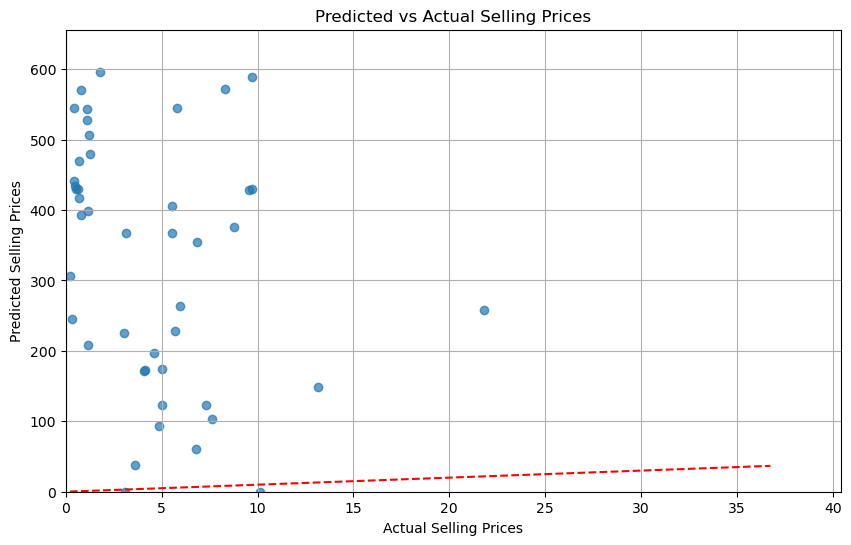

In [12]:
# Make predictions
def make_predictions(model, val_loader):
    model.eval()  # Set the model to evaluation mode
    predictions = []
    actuals = []
    with torch.no_grad():  # Disable gradient calculation
        for batch in val_loader:
            inputs, targets = batch
            outputs = model(inputs)
            predictions.append(outputs)
            actuals.append(targets)
    
    predictions = torch.cat(predictions).numpy()
    actuals = torch.cat(actuals).numpy()
    return predictions, actuals

predictions, actuals = make_predictions(model, val_loader)

# Visualization
def visualize_predictions(predictions, actuals):
    plt.figure(figsize=(10, 6))
    plt.scatter(actuals, predictions, alpha=0.7)
    plt.plot([actuals.min(), actuals.max()], [actuals.min(), actuals.max()], color='red', linestyle='--')  # Line for perfect prediction
    plt.title('Predicted vs Actual Selling Prices')
    plt.xlabel('Actual Selling Prices')
    plt.ylabel('Predicted Selling Prices')
    plt.xlim(0, actuals.max()*1.1)
    plt.ylim(0, predictions.max()*1.1)
    plt.grid()
    plt.show()

visualize_predictions(predictions, actuals)
